# Mean Shift Clustering

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


In [8]:
import numpy as np
import pandas as pd
from copy import copy

class mean_shift:
    
    def __init__(self, bandwidth=1, iters=10, threshold = .1):
        """
        Mean shift measures the density distribution of all
        data and moves each point to the nearest high-density point.
        We'll approximate that by measuring the gaussian kernel
        between points and moving each point based on the weights
        in the original data.
        ---
        KWargs:
        iters: how many steps to take when moving each point
        bandwidth: sets the width of the assumed gaussian kernel
        threshold: if a step isn't at least this large, we stop moving
        the point.
        """
        self._iters = iters
        self.bandwidth = bandwidth
        self.threshold = threshold
        
    def fit(self, X):
        """
        Copies the original data so that we can use that
        to guide our density estimation.
        """
        X = self.convert_to_array(X)
        self._original_data = copy(X)
        
    def transform(self, X):
        """
        For each point, iterate through all points in the 
        original data and measure the strenght of the 
        relationship via the gaussian (rbf) kernel. 
        Track the "pull" from each of these points and then 
        take a step in the direction of the strongest pull
        (which is toward the highest nearby density.)
        ---
        Input: data points (array, dataframe)
        Output: cluster labels
        """
        X = self.convert_to_array(X)
        new_X = []
        for pt in X:
            movement = self.threshold+1
            it=0
            p = copy(pt)
            while it < self._iters and movement > self.threshold:
                shift = np.zeros(len(p))
                scale = 0.
                for orig_pt in self._original_data:
                    weight = self.rbf_kernel(p, orig_pt, sig=self.bandwidth)
                    shift += weight*orig_pt
                    scale += weight
                movement = p - shift/scale
                p = shift/scale
                movement = np.sqrt(np.sum(movement**2))
                it+=1
            new_X.append(p)
            
        self.kernel_points = new_X
        self.labels = self.label_clusters(new_X)
        return self.labels
    
    def label_clusters(self, X):
        """
        Given X, iterate through the points of X and labels
        any points within 1 bandwidth of each other as part
        of the same cluster. 
        ---
        Input: data points, array
        Output: cluster labels, array
        """
        labels = [-1]*len(X)
        idx = list(range(len(X)))
        cluster_id = 0
        
        while np.any(np.array(labels)==-1):
            id1 = idx[0]
            labels[id1] = cluster_id
            idx.remove(id1)
            
            current_idx = copy(idx)
            for id2 in current_idx:
                if self.calculate_distance(X[id1], X[id2]) < self.bandwidth:
                    labels[id2] = cluster_id
                    idx.remove(id2)
            cluster_id += 1
        
        return np.array(labels).reshape(-1,1)
            
        
    def calculate_distance(X, pt1, pt2):
        """
        Given two points, calculate the distance between them.
        """
        return np.sqrt(np.sum((pt1-pt2)**2))
    
    def fit_transform(self, X):
        """
        Use the original training data to construct the 
        reference data, and then convert it to clusters.
        """
        self.fit(X)
        return self.transform(X)
        
    def rbf_kernel(self, x1, x2, sig=1.):
        """
        Returns the rbf affinity between two points (x1 and x2),
        for a given bandwidth (standard deviation).
        ---
        Inputs: 
            x1; point 1(array)
            x2; point 2(array)
            sig; standard deviation (float)
        """
        diff = np.sum((x1-x2)**2)
        norm = 1/(np.sqrt(2*np.pi*sig**2))
        return norm*np.exp(-diff/(2*sig**2))
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
    
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x
   

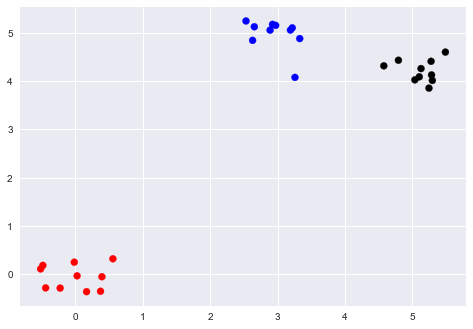

In [9]:
def get_data(n_clust = 3, n_points=50):
    X1 = np.random.normal(0,.3,n_points).reshape(-1,1)
    y1 = np.random.normal(0,.3,n_points).reshape(-1,1)
    for _ in range(n_clust-1):
        X2 = np.random.normal(np.random.randint(0,10),.3,n_points).reshape(-1,1)
        y2 = np.random.normal(np.random.randint(0,10),.3,n_points).reshape(-1,1)
        X1 = np.vstack((X1,X2)).reshape(-1,1)
        y1 = np.vstack((y1,y2)).reshape(-1,1)
    X = np.hstack((X1,y1))
    return X

np.random.seed(44)
X = get_data(n_clust=3, n_points=10)
c = ['r']*10+['b']*10+['k']*10
plt.scatter(X[:,0],X[:,1], c=c);

In [10]:
ms = mean_shift(iters=40, bandwidth=1, threshold=0.01)

In [11]:
ms.fit(X)

In [12]:
X_pred = ms.transform(X)

In [13]:
X_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2]])

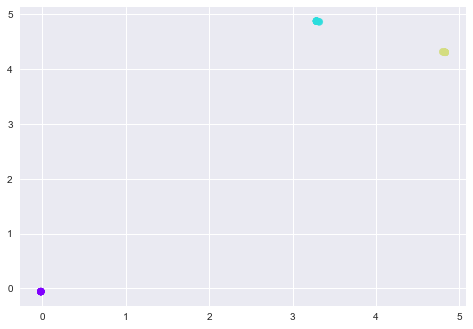

In [14]:
x, y = zip(*ms.kernel_points)
plt.scatter(x,y, c=plt.cm.rainbow(1/3*X_pred.ravel()), alpha=0.8);

## Test in 3D

In [23]:
def get_multidim_data(n_clust = 3, num_dim=3):
    X = np.random.normal(-5,1,size=(50,3))

    for _ in range(n_clust-1):
        X2 = np.random.normal(np.random.randint(-10,10),1,size=(50,3))
        X = np.vstack((X,X2))
    return X
np.random.seed(42)
X = get_multidim_data(n_clust=5)

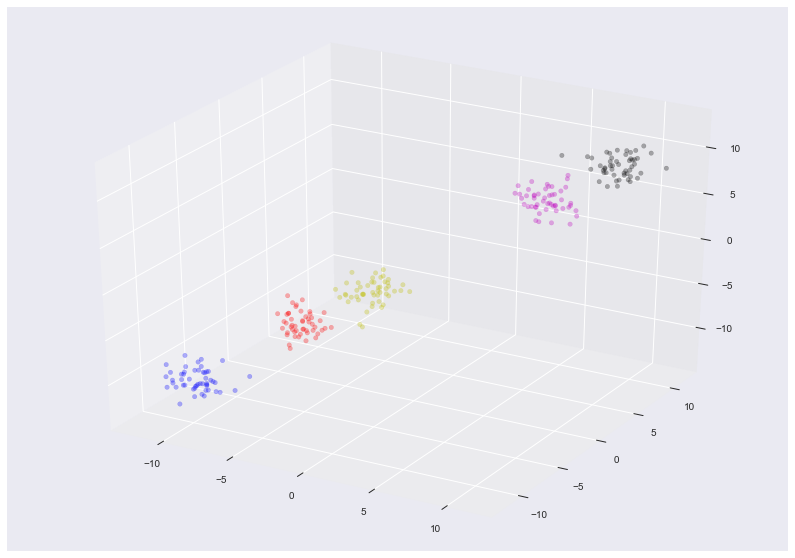

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,10))
ax = fig.gca(projection='3d')
col = ['r']*50+['b']*50+['y']*50+['m']*50+['k']*50

xplot, yplot, zplot = zip(*X)
ax.scatter(xplot,yplot, zplot, c=col,alpha=0.3);

In [25]:
ms = mean_shift(iters=20,threshold=0.01)
preds = ms.fit_transform(X)

In [26]:
preds

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

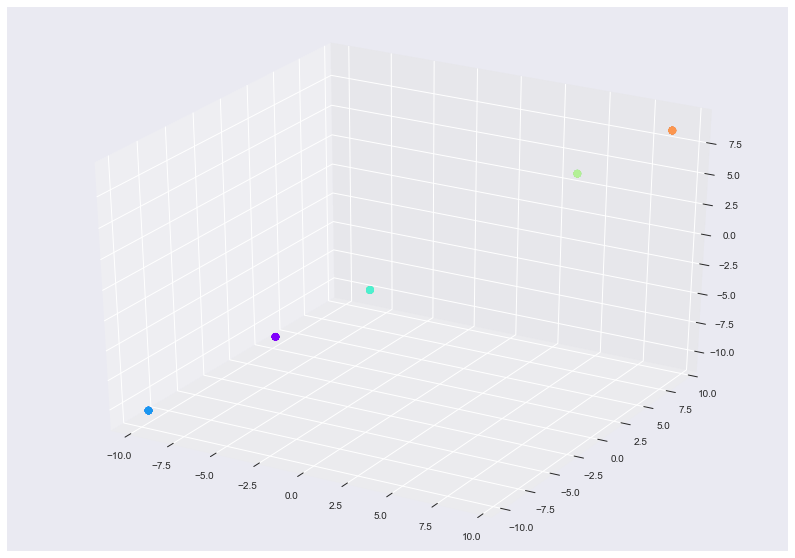

In [27]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,10))
ax = fig.gca(projection='3d')
col = ['r']*50+['b']*50+['y']*50+['m']*50+['k']*50

xplot, yplot, zplot = zip(*ms.kernel_points)
ax.scatter(xplot,yplot, zplot, c=plt.cm.rainbow(1/5*preds.ravel()),alpha=0.3,s=50);
